In [105]:
import keras
from keras.models import Model
from keras.layers import Input, Conv3D, ConvLSTM2D, ConvLSTM3D, BatchNormalization
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import json
import pywt

In [142]:
def DWT(image): 
    h2 = int(image.shape[0]/2) +2
    w2 = int(image.shape[1]/2) +2
    DWT_output = np.zeros([4, h2, w2])
    coeffs = pywt.dwt2(image, 'bior1.3')
    LL, (LH, HL, HH) = coeffs
    
    DWT_output[0] = LL
    DWT_output[1] = LH
    DWT_output[2] = HL
    DWT_output[3] = HH
    
    return DWT_output 

def invDWT(DWTimage):
    reconstructed_image = pywt.idwt2((DWTimage[0], (DWTimage[1],DWTimage[2],DWTimage[3])), 'bior1.3')
    return reconstructed_image

def DWT_tensor(input_data):
    (channel, w, h) = input_data.shape
#     shape_DWT = (N, frame, channel*4, int(w/2), int(h/2))
    
    DWT_outputs = np.zeros([channel*4, int(w/2), int(h/2)])
    for k in range(channel):
        DWT_output = DWT(input_data[k, :,:]) #1: int(w/2)+1, 1:int(h/2)+1]
        DWT_outputs[k*4:(k+1)*4, :, :] = DWT_output[:,1: int(w/2)+1, 1:int(h/2)+1]
    return DWT_outputs


def load_npy(folder, frames): # used for MOD14A2, MOD13Q1
    ndvi_r = folder + '/ratio_*.npy'
    mod11 = folder + '/MOD11A2_*.npy'
    precip = folder + '/monthly_percip.npy'
    ndvi_g = glob(ndvi_r)
    mod11_g = glob(mod11)
    ndvi_g.sort()
    mod11_g.sort()
    precip_list = np.load(precip)

    times = min(len(ndvi_g), len(mod11_g))
    if times < frames:
        return    
    ndvi_g = ndvi_g[-frames:]
    res = np.zeros(shape=(1, frames, dims, dims, channels))
    for i in range(frames):
        arr_11 = np.load(mod11_g[i])
        arr_11 = np.transpose(arr_11, (1, 2, 0))
        #arr_11 = arr_11[12:37, 12:37, :] # center 25x25
        arr_11 = arr_11[np.newaxis, ...]
        arr_11 = arr_11 * 0.0001 # simple normalization bc avg value was around 10000
        
        arr_ndvi = np.load(ndvi_g[i])
        #arr_ndvi = DWT_tensor(arr_ndvi)
        arr_ndvi = np.transpose(arr_ndvi, (1, 2, 0))
        arr_ndvi = arr_ndvi[np.newaxis, ...]

        val_p = precip_list[i]
        arr_precip = np.ones(shape=(1, dims, dims))*val_p
        
        res[:, i, :, :, 0:2] = arr_ndvi
        res[:, i, :, :, 2:4] = arr_11
        res[:, i, :, :, 4] = arr_precip
        

    print(res.shape)
    return res 

In [143]:
dims = 50
frames = 25
channels = 5

path = '/home/fun/wildfire_data/*'
files = glob(path)
file_list = np.array([])
data = np.zeros(shape=(0, frames, dims, dims, channels))

for file in files:
    try:
        prof = file + '/profile.json'
        f = open(prof)
        info = json.load(f)
        if type(info['info']['acres_burned']) != str:
            if info['info']['acres_burned'] >= 10000:
                arr = load_npy(file, frames) # many fires (~30) do not have an acres_burned value, instead it is an empty string "".
                                     # these fires are minor and only last around 1 or 2 months.
                                     # for now, doing a try except to get around this is good enough.
                data = np.append(data, arr, axis=0)
                file_list = np.append(file_list, file)
    except:
        continue


print("FINAL SHAPE:", data.shape)

during = data[:, 0:frames-1, :, :, :] # all but last frame
#during = during[:, :, :, :, np.newaxis]

after = data[:, 1:, :, :, :] # missing first frame (shifted forward 1)
#after = after[:, :, :, :, np.newaxis]
print("x_train shape:", during.shape)
print("y_train shape:", after.shape)

(1, 25, 50, 50, 5)
(1, 25, 50, 50, 5)
(1, 25, 50, 50, 5)
(1, 25, 50, 50, 5)
(1, 25, 50, 50, 5)
(1, 25, 50, 50, 5)
(1, 25, 50, 50, 5)
(1, 25, 50, 50, 5)
(1, 25, 50, 50, 5)
(1, 25, 50, 50, 5)
(1, 25, 50, 50, 5)
(1, 25, 50, 50, 5)
(1, 25, 50, 50, 5)
(1, 25, 50, 50, 5)
(1, 25, 50, 50, 5)
(1, 25, 50, 50, 5)
(1, 25, 50, 50, 5)
(1, 25, 50, 50, 5)
(1, 25, 50, 50, 5)
(1, 25, 50, 50, 5)
(1, 25, 50, 50, 5)
(1, 25, 50, 50, 5)
(1, 25, 50, 50, 5)
(1, 25, 50, 50, 5)
(1, 25, 50, 50, 5)
(1, 25, 50, 50, 5)
(1, 25, 50, 50, 5)
(1, 25, 50, 50, 5)
(1, 25, 50, 50, 5)
(1, 25, 50, 50, 5)
(1, 25, 50, 50, 5)
(1, 25, 50, 50, 5)
(1, 25, 50, 50, 5)
(1, 25, 50, 50, 5)
(1, 25, 50, 50, 5)
(1, 25, 50, 50, 5)
(1, 25, 50, 50, 5)
(1, 25, 50, 50, 5)
(1, 25, 50, 50, 5)
(1, 25, 50, 50, 5)
(1, 25, 50, 50, 5)
(1, 25, 50, 50, 5)
(1, 25, 50, 50, 5)
(1, 25, 50, 50, 5)
(1, 25, 50, 50, 5)
(1, 25, 50, 50, 5)
(1, 25, 50, 50, 5)
(1, 25, 50, 50, 5)
(1, 25, 50, 50, 5)
(1, 25, 50, 50, 5)
FINAL SHAPE: (50, 25, 50, 50, 5)
x_train shape: (5

In [145]:
inp = Input(shape=(None, dims, dims, channels))

x = ConvLSTM2D(filters=128, kernel_size=(3, 3), 
                   padding='same', return_sequences=True, activation="relu")(inp)
x = BatchNormalization()(x)

x = ConvLSTM2D(filters=128, kernel_size=(3, 3),
                   padding='same', return_sequences=True, activation="relu")(x)
x = BatchNormalization()(x)

x = ConvLSTM2D(filters=128, kernel_size=(3, 3),
                   padding='same', return_sequences=True, activation="relu")(x)
x = BatchNormalization()(x)

x = ConvLSTM2D(filters=128, kernel_size=(3, 3),
                   padding='same', return_sequences=True, activation="relu")(x)
x = BatchNormalization()(x)

x = ConvLSTM2D(filters=128, kernel_size=(3, 3),
                   padding='same', return_sequences=True, activation="relu")(x)
x = BatchNormalization()(x)

x = Conv3D(filters=channels, kernel_size=(3, 3, 3),
               activation='sigmoid',
               padding='same', data_format='channels_last')(x)

model = Model(inp, x)
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='mean_squared_error', optimizer=optimizer)

model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, None, 50, 50, 5)  0         
                             ]                                   
                                                                 
 conv_lstm2d_51 (ConvLSTM2D)  (None, None, 50, 50, 128  613376   
                             )                                   
                                                                 
 batch_normalization_51 (Bat  (None, None, 50, 50, 128  512      
 chNormalization)            )                                   
                                                                 
 conv_lstm2d_52 (ConvLSTM2D)  (None, None, 50, 50, 128  1180160  
                             )                                   
                                                                 
 batch_normalization_52 (Bat  (None, None, 50, 50, 128  51

In [48]:
model.fit(during, # timestamps during wildfire
        after, # predictions (timestamps to predict)
        batch_size=10,
        epochs=5,
        validation_split=0.20, 
       )

Epoch 1/5
4/4 [==============================] - 91s 22s/step - loss: 15.7825 - val_loss: 15.7600
Epoch 2/5
4/4 [==============================] - 89s 23s/step - loss: 14.9993 - val_loss: 14.7652
Epoch 3/5
4/4 [==============================] - 88s 22s/step - loss: 14.8773 - val_loss: 14.9890
Epoch 4/5
4/4 [==============================] - 86s 22s/step - loss: 14.4004 - val_loss: 14.6644
Epoch 5/5
4/4 [==============================] - 88s 22s/step - loss: 14.6816 - val_loss: 14.2107


In [115]:
model = keras.models.load_model('/home/fun/plant-predictor/convLSTM_trained')

(25, 50, 50, 4)
/home/fun/wildfire_data/Lion_Fire_2017-09-27


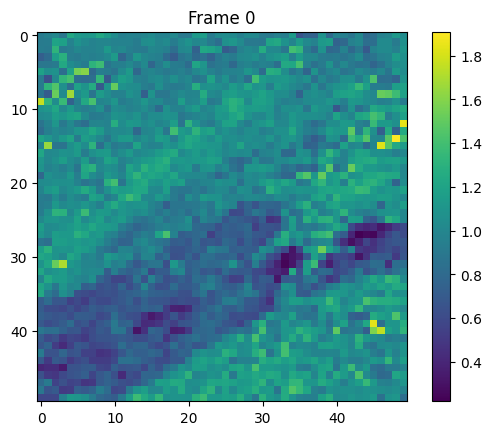

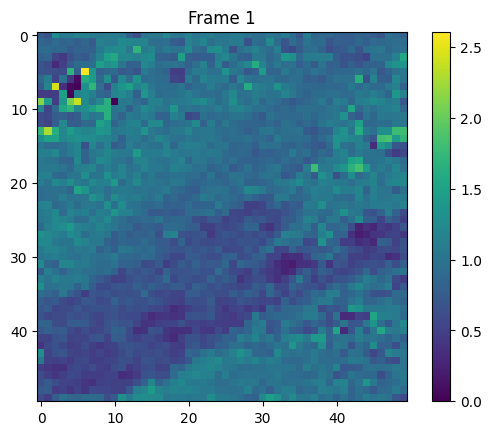

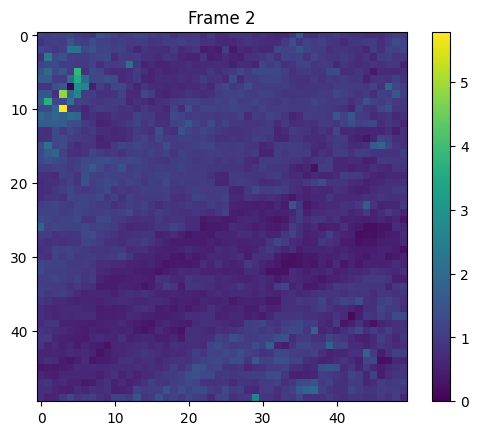

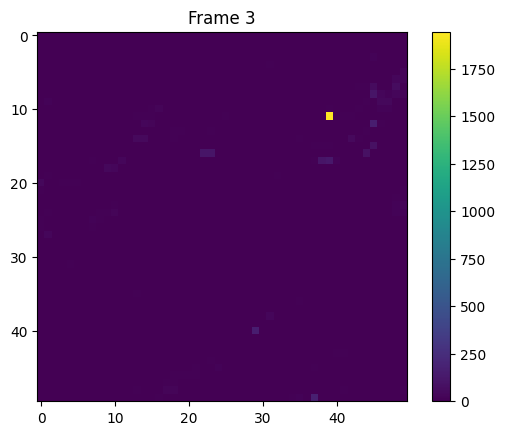

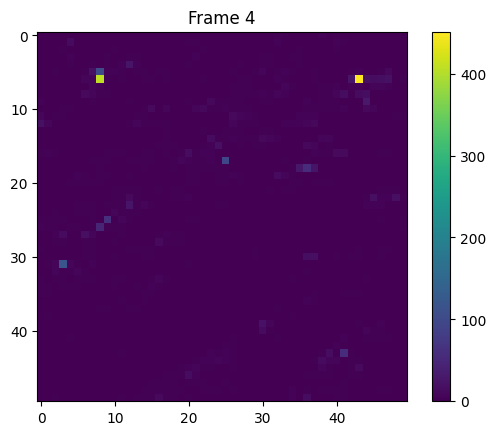

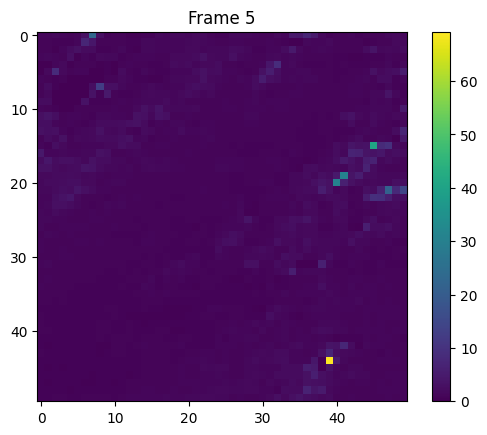

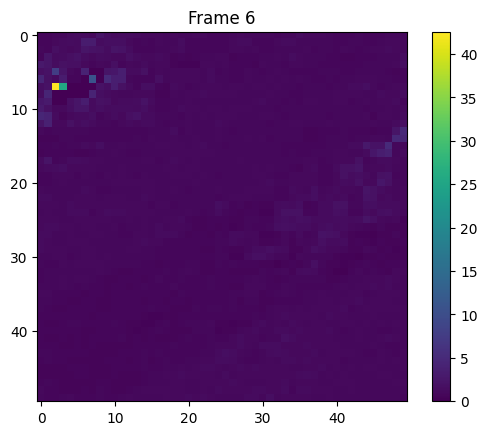

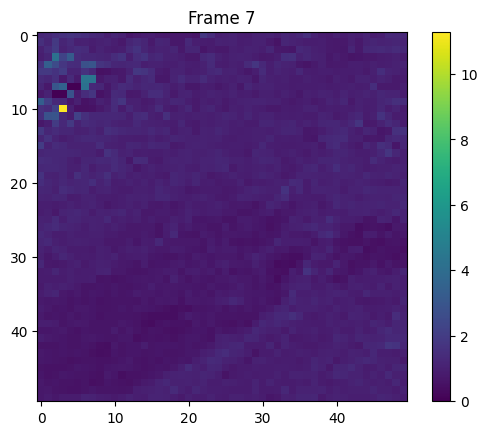

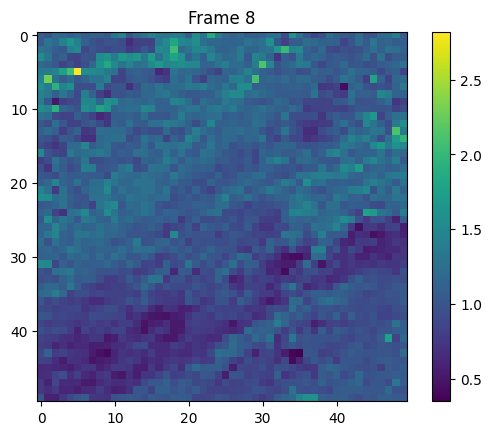

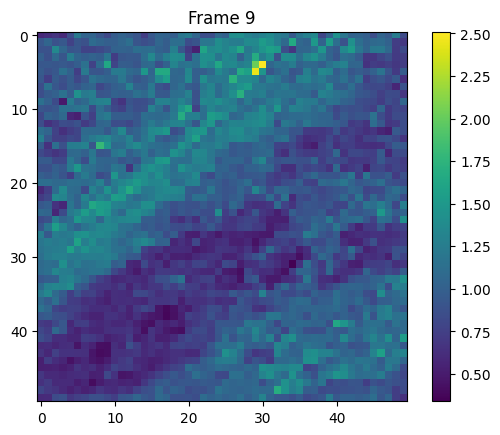

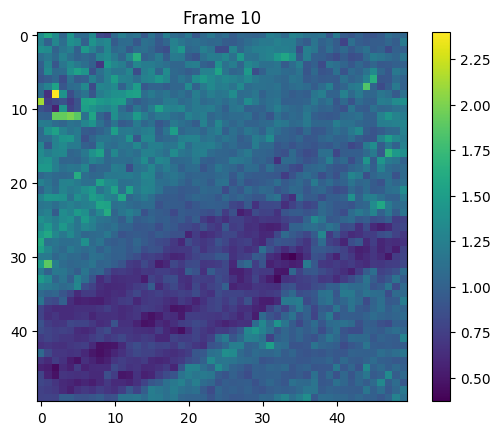

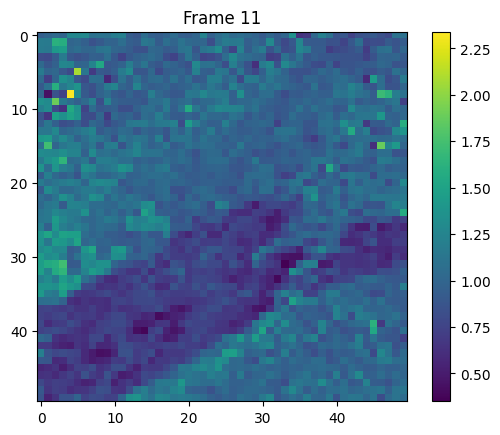

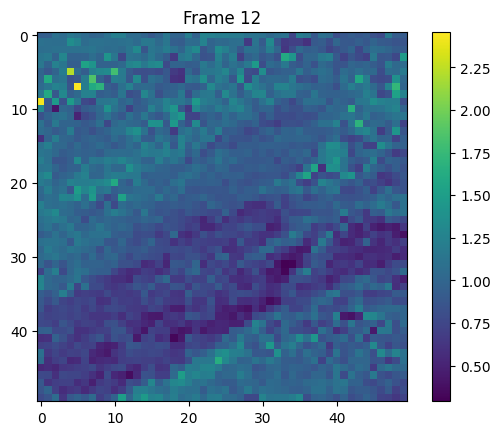

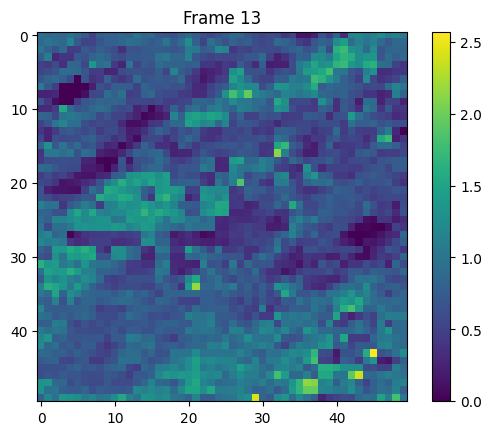

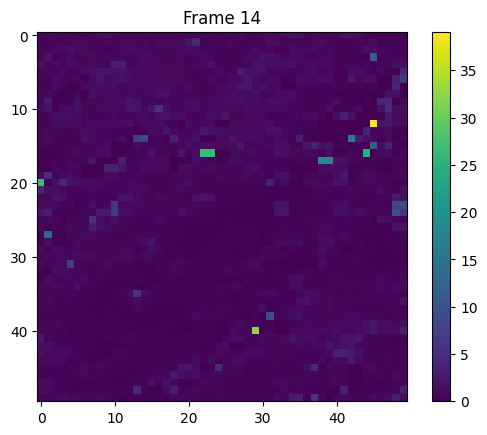

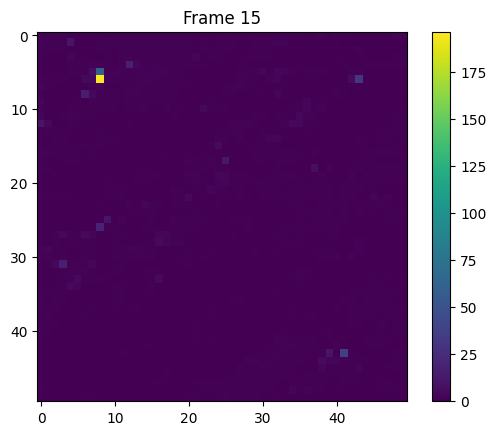

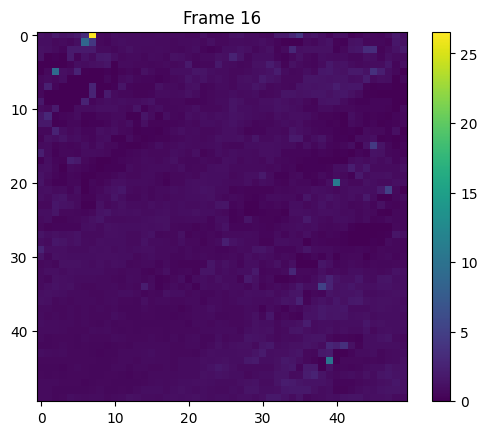

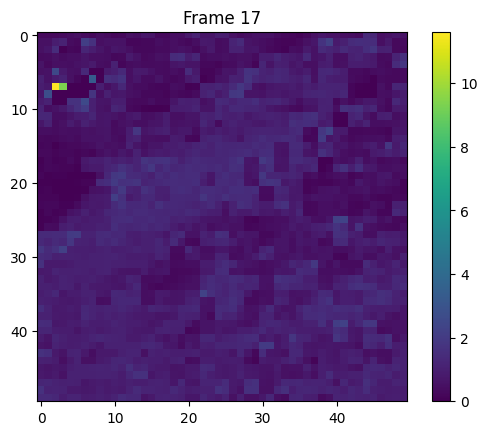

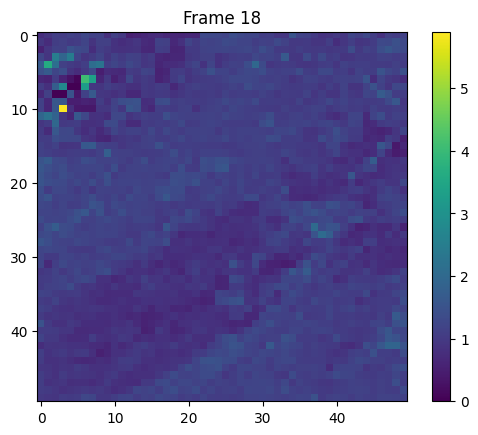

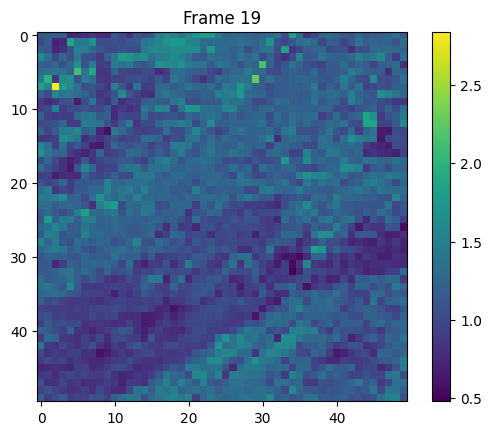

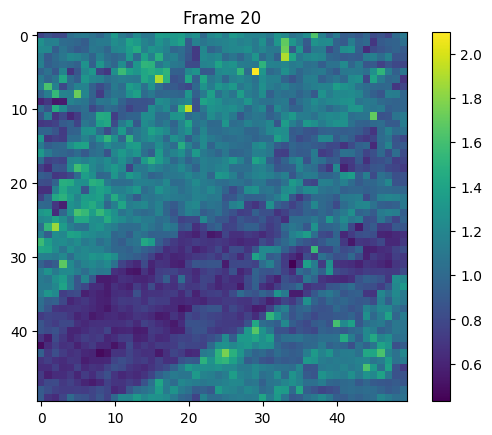

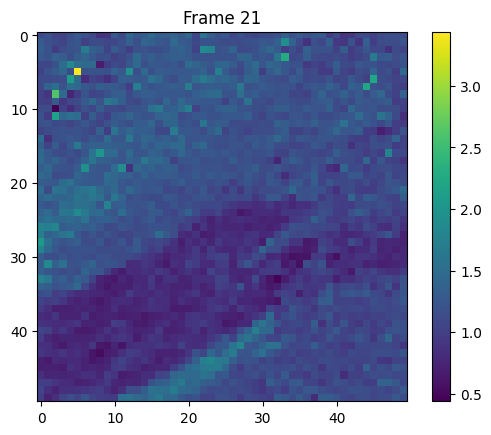

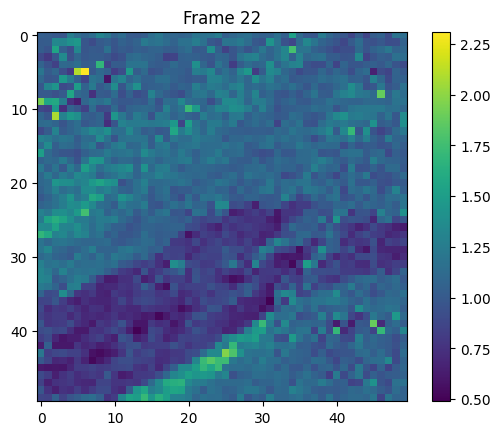

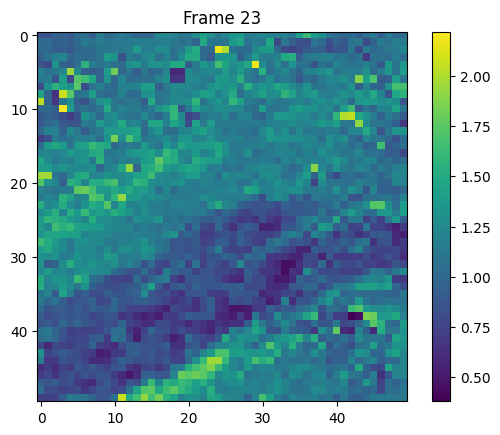

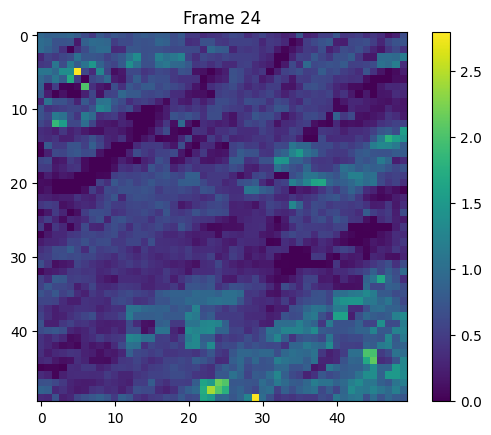

In [108]:
n = np.random.choice(range(len(data)), size=1)[0]
example = data[n]
print(example.shape)
print(file_list[n])

for it in range(len(example)):
    plt.imshow(example[it, :, :, 1])
    plt.title("Frame " + str(it))
    plt.colorbar()
    plt.show()

# for i in range(5):
#     for idx, ax in enumerate(axes[i]):
#         arr = example[idx+5*i, :, :, 1]
#         ax.imshow(arr)
#         ax.set_title(f"Frame {idx + 1 + 5*i}")
#         ax.axis("off")
        


SAMPLE: /home/fun/wildfire_data/Klamathon_Fire_2018-07-05
(15, 50, 50, 4) (10, 50, 50, 4)
1/1 [==============================] - 2s 2s/step


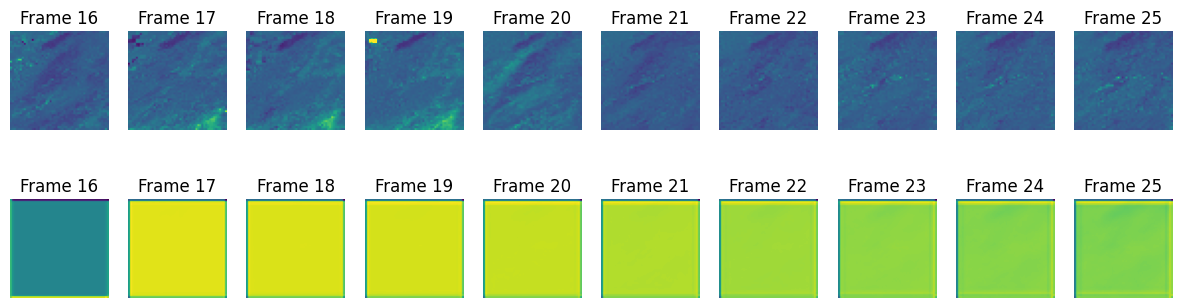

In [118]:
n = np.random.choice(range(len(data)), size=1)[0]
print("SAMPLE:", file_list[n])

example = data[n]
sample = example[:15, :, :, :]
actual = example[15:, :, :, :]
print(sample.shape, actual.shape)


for _ in range(10):
    new_prediction = model.predict(np.expand_dims(sample, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    sample = np.concatenate((sample, predicted_frame), axis=0)

fig, axes = plt.subplots(2, 10, figsize=(15, 4))

for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(actual[idx, :, :, 0]), vmin=0, vmax=3)
    ax.set_title(f"Frame {idx + 16}")
    ax.axis("off")

new_frames = sample[15:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_prediction[idx, :, :, 0]))
    ax.set_title(f"Frame {idx + 16}")
    ax.axis("off")

plt.show()